In [46]:
import scipy
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import xarray as xr

from scipy.stats import norm, binom

### 個体差のある階層ベイズモデル

In [2]:
#CSVデータの読み込み
data = pd.read_csv("chap10_dataA.csv")
data.head()

,id,y
0,1,0
1,2,2
2,3,7
3,4,8
4,5,1


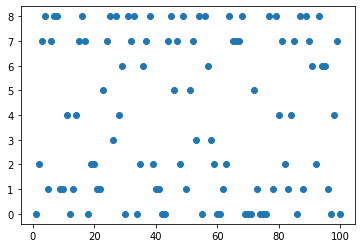

In [3]:
#x軸にid,y軸に生存種子数を指定
plt.scatter(data.id, data.y)

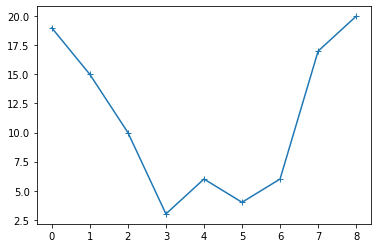

In [4]:
#x軸に生存種子数,y軸に頻度
plt.plot(data.y.value_counts().sort_index(), marker='+')
plt.show()

In [5]:
data.y.describe()

count    100.000000
mean       4.030000
std        3.150934
min        0.000000
25%        1.000000
50%        4.000000
75%        7.000000
max        8.000000
Name: y, dtype: float64

In [6]:
#value_countsの使い方
#これをsortすればx軸が生存種子数でy軸が頻度となる
data.y.value_counts()

8    20
0    19
7    17
1    15
2    10
4     6
6     6
5     4
3     3
Name: y, dtype: int64

In [7]:
#平均
print(data.y.mean())
#分散
print(data.y.var())
#分散は2よりも大きいため過分散
#8 * 0.4 * 0.6 = 2
#GLMではなくGLMMを用いる
#計算量が多いのでMCMCを利用する

4.03
9.928383838383839


In [8]:
with pm.Model() as model:
    #βの事前分布をN(0, 100)の正規分布で設定(無情報事前分布)
    beta = pm.Normal('beta', mu=0, sd=100)
    
    #超パラメータsの(超)事前分布をU(0, 10000)の連続一様分布で設定(無情報事前分布)
    s = pm.Uniform('s', lower=0, upper=10000)
    
    #パラメータrの事前分布をN(0, s)の正規分布で設定(階層事前分布)
    r = pm.Normal('r', mu=0, sd=s, shape=len(data.y))
    
    #ロジットリンク関数を設定し、二項分布で推定する
    y = pm.Binomial('y', n=8, p=pm.invlogit(beta + r), observed=data.y.values)

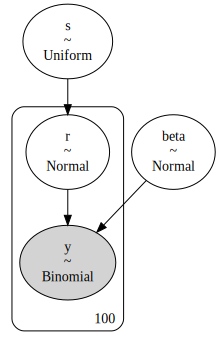

In [9]:
#モデルの可視化
pm.model_to_graphviz(model)

/tmp/ipykernel_1368/1641089276.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1500, tune=100)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, s, beta]


Sampling 4 chains for 100 tune and 1_500 draw iterations (400 + 6_000 draws total) took 19 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9266441938974445, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9277462177591581, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9249015943363359, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9208709930678677, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/tmp/ipykernel_1368/1641089276.py:6: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.041,0.342,-0.602,0.689,0.010,0.007,1113.0,1905.0,1.0
s,3.030,0.362,2.379,3.706,0.007,0.005,2400.0,3563.0,1.0


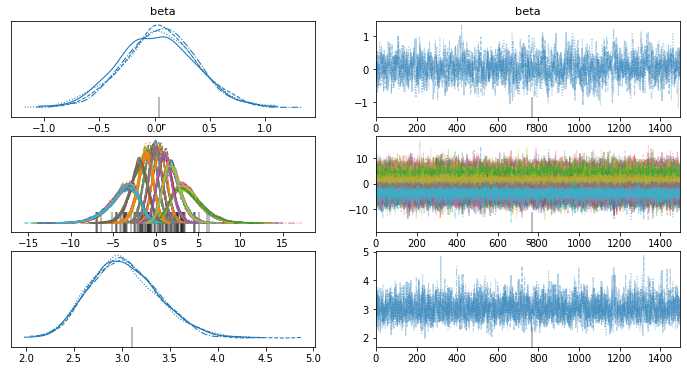

In [10]:
with model:
    #最初の100個は捨てる=101個目からサンプルとして取得する
    #NUTSで101個目からサンプルを取得するチェインを2つ作る
    trace = pm.sample(1500, tune=100)
    
_ = pm.traceplot(trace)
pm.summary(trace).loc[['beta', 's']]

#traceplotにおいてバグが存在する模様
#https://github.com/arviz-devs/arviz/issues/988

In [11]:
#サンプリングに利用したchainがリストで表示される
trace.chains

[0, 1, 2, 3]

In [12]:
#nchainsでchainの総数を取得できる
trace.nchains

4

In [13]:
#サンプリングした値を参照できる
print(trace.get_values('beta'))
print(trace.get_values('r'))

[ 0.2702247  -0.23856768  0.09492182 ... -0.09464482 -0.0661972
 -0.34129061]
[[-6.31799121 -2.10188212  1.07846812 ... -0.63673829  2.35525244
  -2.96261835]
 [-3.95487254 -0.18278234  2.7190821  ...  0.05266585  1.04598893
  -4.9539156 ]
 [-5.23073513 -0.16842635  3.1362613  ... -0.15985541  0.79183134
  -5.01622187]
 ...
 [-2.50914989 -0.80527569  0.92511264 ... -0.13757409  1.43324323
  -5.38541848]
 [-4.47964129 -1.10948735  1.1969255  ...  0.41979871  1.49504784
  -4.23243881]
 [-2.38169765 -0.57879849  2.91968126 ...  0.00914011  2.37341129
  -2.83220981]]


In [14]:
#chainを指定しての取得も可能
print(trace.get_values('beta', chains=0))
print(len(trace.get_values('r', chains=1)))

[ 0.2702247  -0.23856768  0.09492182 ...  0.5447675   0.30962737
  0.01451705]
1500


In [15]:
#各サンプリングの個数を取得
#指定したサンプル数 * chainの数だけ保存されている
print(len(trace.get_values('beta')))
print(len(trace.get_values('r')))

#traceの個数とchainのサンプル毎の個数は別に扱われる
print(len(trace))

6000
6000
1500


In [16]:
#事後分布p(β|Y), p(s|Y)を3つのサンプル列の平均値で求める

#まずは入れ物を作る
beta_averages = np.zeros(len(trace), dtype=np.float64)
s_averages = np.zeros(len(trace), dtype=np.float64)

In [17]:
#1500個のサンプルしたbetaおよびsを取得
#1500個づつのchainの平均を求める

for i in trace.chains:
    beta_averages += trace.get_values('beta', chains=i) / trace.nchains
    s_averages += trace.get_values('s', chains=i) / trace.nchains

In [18]:
# シグモイド関数
sigmoid = lambda beta, r: 1 / (1 + np.exp(-(beta + r)))

In [19]:
#全サンプル・全個体の種子数yの生存確率を計算
#本アプローチの考え方:
#1500のchain平均それぞれの値を基に、種子数が0から8の各場合の生存確率を求める
#その際には100個のサンプルを生成する
#つまり1500 * 100 * 9個のデータが存在する

probs = []

for (beta, s) in zip(beta_averages, s_averages):
    individuals_probs = []
    
    #s基づいて100個体を生成
    for r in norm.rvs(loc=0, scale=s, size=100):
        y_probs = []
        
        # 各個体の種子数(0〜8個)の生存確率を計算
        for y in range(9):
            y_probs.append(binom.pmf(y, 8, sigmoid(beta, r)))
            
        individuals_probs.append(y_probs)
        
    probs.append(individuals_probs)
    
probs = np.array(probs)

print(probs.shape) # (1500, 100, 9)

(1500, 100, 9)


In [20]:
#probsの中身の確認
probs[0,0,:]

array([0.00051663, 0.00651143, 0.03590439, 0.11313066, 0.2227887 ,
       0.28079281, 0.2211866 , 0.099562  , 0.01960679])

In [21]:
print(np.average(probs, axis=0).shape)
print(np.average(probs, axis=1).shape)
print(np.average(probs, axis=2).shape)

(100, 9)
(1500, 9)
(1500, 100)


Text(0, 0.5, 'y')

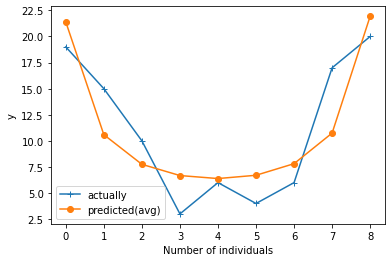

In [22]:
#ベイズ推定の推定結果はデータと近い結果になった
plt.plot(data.y.value_counts().sort_index(), marker='+', label='actually')
#100個の平均を取り(1500, 9)、その後9個の平均をとる(9)
plt.plot(np.average(np.average(probs, axis=1), axis=0) * 100, marker='o', label='predicted(avg)')
plt.legend()
plt.xlabel('Number of individuals')
plt.ylabel('y')

## 10.5 個体差＋場所差の階層ベイズモデル

In [23]:
# DataFrameへロード
data = pd.read_csv('chap10_dataB.csv')

data.head()

,id,pot,f,y
0,1,A,C,6
1,2,A,C,3
2,3,A,C,19
3,4,A,C,5
4,5,A,C,0


Text(0, 0.5, 'y')

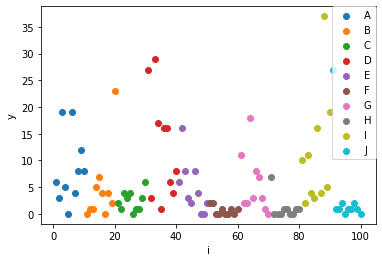

In [24]:
# 個体ごとの分布をプロット
for pot in data.pot.unique():
    plt.scatter(data[data.pot == pot].id, data[data.pot == pot].y, label=pot)
    
plt.legend(loc='upper right', borderaxespad=0)
plt.xlabel('i')
plt.ylabel('y')

[]

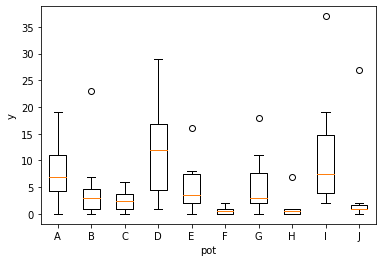

In [25]:
# 植木鉢ごとの分布を箱ひげ図でプロット
plt.boxplot([data[data.pot == p].y for p in data.pot.unique()], labels=data.pot.unique())
plt.xlabel('pot')
plt.ylabel('y')
plt.plot()

In [26]:
# T(施肥処理有り)の場合に1となる変数Fを追加
data['F'] = pd.get_dummies(data.f)['T']
# A〜Jを0〜9に対応付けた変数POTを追加
data['POT'] = data.pot.apply(lambda p: ord(p) - ord('A'))

data.head(3)

,id,pot,f,y,F,POT
0,1,A,C,6,0,0
1,2,A,C,3,0,0
2,3,A,C,19,0,0


In [27]:
POT_idx, POT = pd.factorize(data.pot)
POT_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

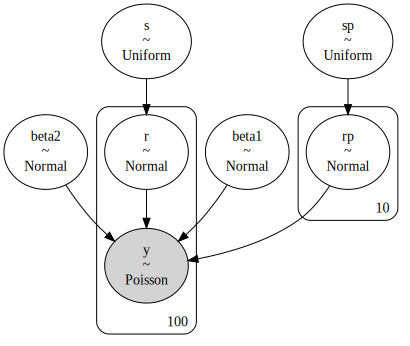

In [ ]:
with pm.Model() as model:
    # β1とβ2の事前分布をN(0, 100)の正規分布で設定(無情報事前分布)
    beta1 = pm.Normal('beta1', mu=0, sd=100)
    beta2 = pm.Normal('beta2', mu=0, sd=100)
    
    # sとspの(超)事前分布をU(0, 10000)の連続一様分布で設定(無情報事前分布)
    s = pm.Uniform('s', lower=0, upper=10000)
    sp = pm.Uniform('sp', lower=0, upper=10000)
    
    # 個体差パラメータrの事前分布をN(0, s)の正規分布で設定(階層事前分布)
    r = pm.Normal('r', mu=0, sd=s, shape=len(data.y))
    
    # 場所差パラメータrpの事前分布をN(0, sp)の正規分布で設定(階層事前分布)
    rp = pm.Normal('rp', mu=0, sd=sp, shape=len(data.POT.unique()))
    
    # ログリンク関数を設定し、ポアソン分布で推定する
    y = pm.Poisson('y', mu=np.exp(beta1 + beta2 * data.F + r + rp[data.POT]), observed=data.y.values)
    
pm.model_to_graphviz(model)
    

/tmp/ipykernel_673/2060338412.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1500, step=pm.HamiltonianMC(), tune=100, random_seed=0)
Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [rp, r, sp, s, beta2, beta1]


Sampling 4 chains for 100 tune and 1_500 draw iterations (400 + 6_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.9194294585385405, but should be close to 0.65. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8953770068047306, but should be close to 0.65. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.909762855132613, but should be close to 0.65. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9081486647915217, but should be close to 0.65. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/tmp/ipykernel_673/2060338412.py:6: DeprecationWa

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta1,1.365,0.537,0.317,2.368,0.015,0.011,1302.0,1746.0,1.0
beta2,-0.857,0.772,-2.361,0.594,0.020,0.014,1515.0,1762.0,1.0
s,1.018,0.115,0.817,1.242,0.002,0.002,2579.0,3431.0,1.0
sp,1.077,0.400,0.479,1.802,0.012,0.009,1030.0,2035.0,1.0


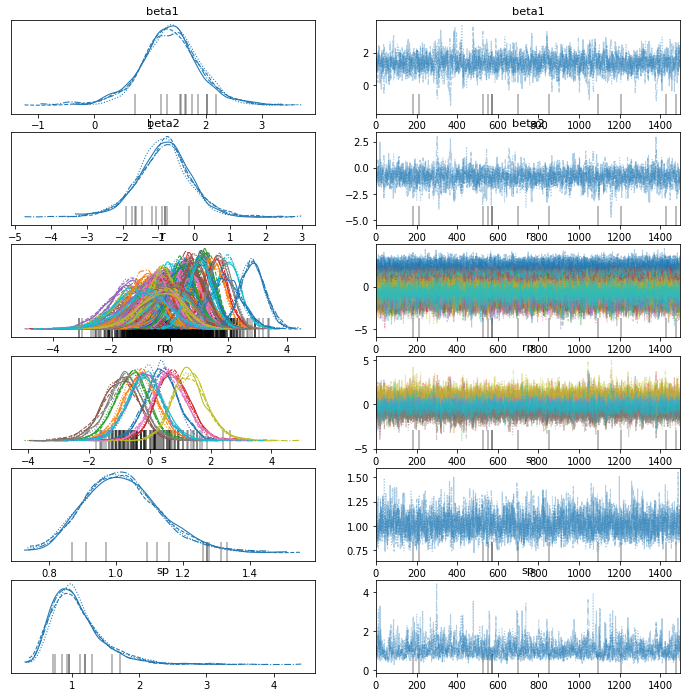

In [ ]:

# HMCでサンプリング
with model:
    # 101個目からサンプルを取得するチェインを3つ作る
    trace = pm.sample(1500, step=pm.HamiltonianMC(), tune=100, random_seed=0)
    
_ = pm.traceplot(trace)

pm.summary(trace).loc[['beta1', 'beta2', 's', 'sp']]

In [29]:
POT_idx, POT = pd.factorize(data.pot)
POT_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [30]:
le=LabelEncoder()
encoded_pot=le.fit_transform(data["pot"].values)
decoder_pot=le.inverse_transform(encoded_pot)
data["encoded_pot"]=encoded_pot
data

encoded_f=le.fit_transform(data["f"].values)
decoded_f=le.inverse_transform(encoded_f)
data["encoded_f"]=encoded_f
data


,id,pot,f,y,F,POT,encoded_pot,encoded_f
0,1,A,C,6,0,0,0,0
1,2,A,C,3,0,0,0,0
2,3,A,C,19,0,0,0,0
3,4,A,C,5,0,0,0,0
4,5,A,C,0,0,0,0,0
...,...,...,...,...,...,...,...,...
95,96,J,T,1,1,9,9,1
96,97,J,T,1,1,9,9,1
97,98,J,T,2,1,9,9,1
98,99,J,T,1,1,9,9,1


In [31]:
coords={
  "pot":data.pot.unique(),
  "obs_id":data.index.values
}
coords

{'pot': array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype=object),
 'obs_id': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])}

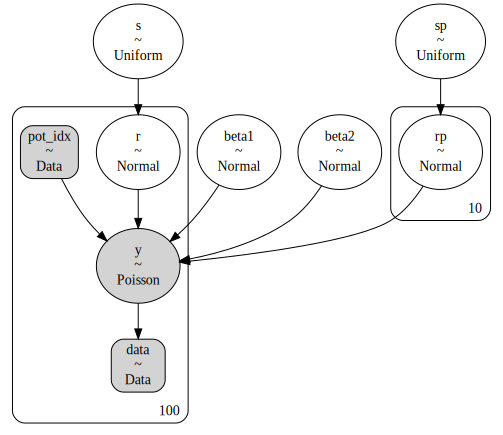

In [55]:
with pm.Model(coords=coords) as hierarchical_model:
    pot_idx=pm.Data("pot_idx",data.encoded_pot.values, dims="obs_id")
  
    # β1とβ2の事前分布をN(0, 100)の正規分布で設定(無情報事前分布)
    beta1 = pm.Normal('beta1', mu=0, sd=100)
    beta2 = pm.Normal('beta2', mu=0, sd=100)
    
    # sとspの(超)事前分布をU(0, 10000)の連続一様分布で設定(無情報事前分布)
    s = pm.Uniform('s', lower=0, upper=10000)
    sp = pm.Uniform('sp', lower=0, upper=10000)
    
    # 個体差パラメータrの事前分布をN(0, s)の正規分布で設定(階層事前分布)
    r = pm.Normal('r', mu=0, sd=s, shape=len(data.y))
    
    # 場所差パラメータrpの事前分布をN(0, sp)の正規分布で設定(階層事前分布)
    rp = pm.Normal('rp', mu=0, sd=sp, dims="pot")
    
    # ログリンク関数を設定し、ポアソン分布で推定する
    d=pm.Data("data", data.y.values, dims=("obs_id"))
    y_est=np.exp(beta1 + beta2 * data.F + r + rp[pot_idx])
    y = pm.Poisson('y', mu=y_est, observed=d, dims="obs_id")

pm.model_to_graphviz(hierarchical_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rp, r, sp, s, beta2, beta1]


Sampling 4 chains for 100 tune and 1_500 draw iterations (400 + 6_000 draws total) took 27 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9208266634355814, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9392324590179238, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9194452058300135, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9306659271630136, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/tmp/ipykernel_1368/3748961982.py:10: DeprecationWarnin

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta1,1.368,0.513,0.408,2.352,0.017,0.012,974.0,1527.0,1.0
beta2,-0.881,0.894,-2.292,0.632,0.043,0.041,893.0,860.0,1.0
s,1.019,0.117,0.812,1.248,0.002,0.002,2483.0,3253.0,1.0
sp,1.061,0.491,0.441,1.732,0.024,0.020,1576.0,992.0,1.0


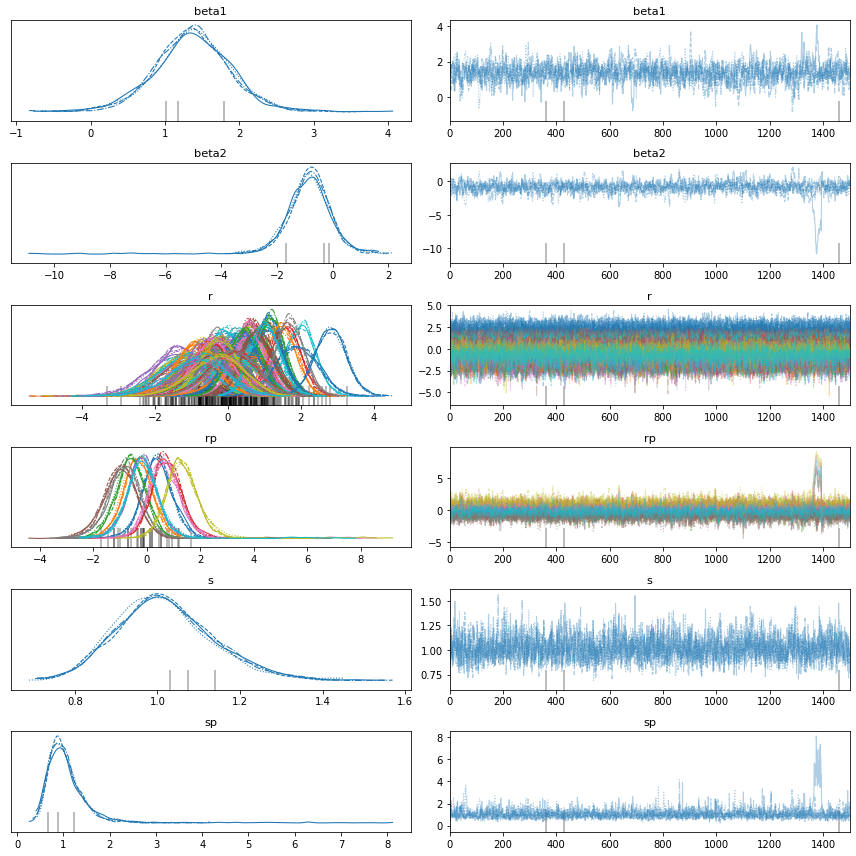

In [56]:
# HMCでサンプリング
with hierarchical_model:
    # 101個目からサンプルを取得するチェインを3つ作る
    trace = pm.sample(
        1500,  
        tune=100, 
        random_seed=0,
        return_inferencedata=True)
    
_ = pm.traceplot(trace)
plt.tight_layout()
pm.summary(trace).loc[['beta1', 'beta2', 's', 'sp']]

In [57]:
hierarchical_model.coords

{'pot': array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype=object),
 'obs_id': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])}

In [58]:
trace.posterior.coords

Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1493 1494 1495 1496 1497 1498 1499
  * r_dim_0  (r_dim_0) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * pot      (pot) object 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J'

In [43]:
hierarchical_model["data"].get_value()

array([ 6,  3, 19,  5,  0, 19,  4,  8, 12,  8,  0,  1,  1,  5,  7,  4,  0,
        4,  2, 23,  2,  1,  4,  3,  4,  0,  1,  1,  3,  6, 27,  3, 29, 17,
        1, 16, 16,  6,  4,  8,  6, 16,  8,  3,  2,  8,  4,  0,  0,  2,  2,
        2,  0,  0,  1,  0,  0,  1,  0,  1, 11,  2,  2, 18,  3,  8,  7,  3,
        1,  0,  7,  0,  0,  0,  1,  1,  0,  0,  1,  1, 10,  2, 11,  4,  3,
       16,  4, 37,  5, 19, 27,  1,  1,  2,  0,  1,  1,  2,  1,  0])

In [54]:
selection=["A", "B"]
xvals = xr.DataArray(np.linspace(-0.2, 1.2, num=10), dims=["x_plot"])

hier_post=trace.posterior.stack(chain_draw=("chain", "draw"))


<xarray.Dataset>
Dimensions:     (chain_draw: 6000, r_dim_0: 100, pot: 10)
Coordinates:
  * r_dim_0     (r_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * pot         (pot) object 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J'
  * chain_draw  (chain_draw) MultiIndex
  - chain       (chain_draw) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  - draw        (chain_draw) int64 0 1 2 3 4 5 ... 1494 1495 1496 1497 1498 1499
Data variables:
    beta1       (chain_draw) float64 1.139 2.033 1.823 ... 1.433 1.135 1.622
    beta2       (chain_draw) float64 -0.6743 -1.814 -1.695 ... -0.2113 -0.7148
    r           (r_dim_0, chain_draw) float64 0.1602 -1.081 ... 0.1413 -1.409
    rp          (pot, chain_draw) float64 0.6045 0.401 0.1005 ... 0.2015 -0.7157
    s           (chain_draw) float64 1.087 1.22 1.001 ... 0.9842 0.9077 0.854
    sp          (chain_draw) float64 0.7142 1.742 1.583 ... 1.08 0.8469 0.945
Attributes:
    created_at:                 2021-12-18T21:21:31.508779
    arviz_version:              0.11.4
    inference_library:          pymc3
    inference_library_version:  3.11.4
    sampling_time:              27.42396116256714
    tuning_steps:               100

In [67]:
hier_post["pot"].isel(pot=trace.constant_data["pot_idx"])

<xarray.DataArray 'pot' (obs_id: 100)>
array(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B',
       'B', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'E', 'E',
       'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G',
       'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'J', 'J', 'J', 'J', 'J', 'J', 'J', 'J',
       'J', 'J'], dtype=object)
Coordinates:
    pot      (obs_id) object 'A' 'A' 'A' 'A' 'A' 'A' ... 'J' 'J' 'J' 'J' 'J' 'J'
  * obs_id   (obs_id) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99

In [ ]:
hier_post["pot"].isel(pot=data.encoded_pot)

<xarray.DataArray 'pot' (pot: 100)>
array(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B',
       'B', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'E', 'E',
       'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'F', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'F', 'F', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G',
       'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'J', 'J', 'J', 'J', 'J', 'J', 'J', 'J',
       'J', 'J'], dtype=object)
Coordinates:
  * pot      (pot) object 'A' 'A' 'A' 'A' 'A' 'A' ... 'J' 'J' 'J' 'J' 'J' 'J'

In [78]:
trace.log_likelihood.y

<xarray.DataArray 'y' (chain: 4, draw: 1500, obs_id: 100)>
array([[[-1.86811963, -1.4977632 , -2.40714247, ..., -1.64039773,
         -1.06103887, -0.96925989],
        [-2.32923501, -1.80665829, -2.50669233, ..., -1.4322585 ,
         -1.05235704, -0.23249561],
        [-1.90012989, -1.56550484, -3.09066621, ..., -1.37880074,
         -1.38743908, -2.4065335 ],
        ...,
        [-2.55374596, -1.96150735, -2.74147428, ..., -1.38071654,
         -1.00742002, -0.64022652],
        [-2.70246286, -2.14342861, -4.89662983, ..., -1.38508577,
         -1.16249534, -0.47775336],
        [-2.30133303, -1.84207121, -2.66638583, ..., -1.46056956,
         -1.03332199, -1.53820994]],

       [[-1.89956453, -1.59097446, -2.81908892, ..., -1.5079856 ,
         -1.00062519, -1.97068082],
        [-1.9338979 , -1.49634987, -2.97583556, ..., -1.33048652,
         -1.06976046, -0.3350208 ],
        [-2.29855544, -1.57999094, -2.40341341, ..., -1.47271946,
         -1.01234792, -0.49088603],
...
        [-2.0562846 , -2.21871098, -5.1922716 , ..., -1.51152213,
         -1.02630086, -0.5152507 ],
        [-2.02208402, -1.49710113, -2.40178224, ..., -1.30827715,
         -1.02711798, -0.85811732],
        [-1.87862046, -1.60105416, -2.82397592, ..., -1.53623798,
         -1.03591668, -0.40070896]],

       [[-2.04966234, -1.51436475, -4.20423778, ..., -1.43577911,
         -1.00166985, -1.02715115],
        [-3.80751356, -2.01192462, -2.42496404, ..., -1.93400711,
         -1.0738663 , -1.77987702],
        [-3.73201325, -1.7333904 , -4.31255806, ..., -1.5683215 ,
         -1.28676448, -0.49463621],
        ...,
        [-1.84478684, -2.05257261, -5.47516534, ..., -1.64247373,
         -1.02868761, -0.171533  ],
        [-1.90285135, -2.33126481, -4.25770954, ..., -1.41463516,
         -1.51729689, -3.54895156],
        [-1.94513208, -1.90854657, -4.33924852, ..., -1.71253225,
         -1.00477648, -0.29609596]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1493 1494 1495 1496 1497 1498 1499
  * obs_id   (obs_id) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99

In [101]:
hier_est=(hier_post["beta1"]+hier_post["beta2"]*xvals+hier_post["r"]+hier_post["rp"]).transpose("x_plot", ...)
hier_est

<xarray.DataArray (x_plot: 10, chain_draw: 6000, r_dim_0: 100, pot: 10)>
array([[[[ 2.03911099e+00,  1.57595608e+00,  1.80902155e+00, ...,
           7.80697250e-01,  2.46762507e+00,  1.35497844e+00],
         [ 1.19824029e+00,  7.35085384e-01,  9.68150853e-01, ...,
          -6.01734505e-02,  1.62675437e+00,  5.14107741e-01],
         [ 3.11404170e+00,  2.65088680e+00,  2.88395227e+00, ...,
           1.85562796e+00,  3.54255578e+00,  2.42990915e+00],
         ...,
         [ 1.54755925e+00,  1.08440435e+00,  1.31746982e+00, ...,
           2.89145513e-01,  1.97607333e+00,  8.63426705e-01],
         [ 1.82349230e+00,  1.36033740e+00,  1.59340286e+00, ...,
           5.65078561e-01,  2.25200638e+00,  1.13935975e+00],
         [ 1.46208892e+00,  9.98934018e-01,  1.23199949e+00, ...,
           2.03675183e-01,  1.89060300e+00,  7.77956375e-01]],

        [[ 1.71624557e+00,  2.40351409e-01,  7.93827638e-01, ...,
           9.38599753e-01,  2.35149761e+00,  8.97252202e-01],
         [ 1.88445772e+00,  4.08563552e-01,  9.62039781e-01, ...,
           1.10681190e+00,  2.51970976e+00,  1.06546434e+00],
         [ 3.19704878e+00,  1.72115461e+00,  2.27463084e+00, ...,
           2.41940296e+00,  3.83230082e+00,  2.37805541e+00],
...
         [ 1.65846312e+00,  1.19311461e+00,  3.27017678e-01, ...,
           1.92667548e-01,  1.99272927e+00,  9.62172175e-01],
         [ 1.52431489e+00,  1.05896638e+00,  1.92869445e-01, ...,
           5.85193149e-02,  1.85858104e+00,  8.28023942e-01],
         [ 1.92068884e+00,  1.45534033e+00,  5.89243394e-01, ...,
           4.54893264e-01,  2.25495499e+00,  1.22439789e+00]],

        [[ 1.12479733e+00,  4.36117307e-01, -7.11853577e-01, ...,
          -1.07518119e+00,  2.06609996e+00, -1.12220756e-01],
         [-3.33722932e-01, -1.02240296e+00, -2.17037384e+00, ...,
          -2.53370145e+00,  6.07579697e-01, -1.57074102e+00],
         [ 2.50737796e+00,  1.81869794e+00,  6.70727054e-01, ...,
           3.07399443e-01,  3.44868059e+00,  1.27035988e+00],
         ...,
         [ 1.07486465e+00,  3.86184622e-01, -7.61786262e-01, ...,
          -1.12511387e+00,  2.01616728e+00, -1.62153441e-01],
         [ 1.19023927e+00,  5.01559245e-01, -6.46411638e-01, ...,
          -1.00973925e+00,  2.13154190e+00, -4.67788173e-02],
         [-1.23005146e-01, -8.11685172e-01, -1.95965606e+00, ...,
          -2.32298367e+00,  8.18297483e-01, -1.36002323e+00]]]])
Coordinates:
  * chain_draw  (chain_draw) MultiIndex
  - chain       (chain_draw) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  - draw        (chain_draw) int64 0 1 2 3 4 5 ... 1494 1495 1496 1497 1498 1499
  * r_dim_0     (r_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * pot         (pot) object 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J'
Dimensions without coordinates: x_plot

In [109]:
rng=np.random.default_rng(0)
rng.permutation(np.arange(10))

array([4, 6, 2, 7, 3, 5, 9, 0, 8, 1])

In [115]:
hier_est.sel(pot="A")

<xarray.DataArray (x_plot: 10, chain_draw: 6000, r_dim_0: 100)>
array([[[ 2.03911099,  1.19824029,  3.1140417 , ...,  1.54755925,
          1.8234923 ,  1.46208892],
        [ 1.71624557,  1.88445772,  3.19704878, ...,  4.02311119,
          2.65353107,  1.53667764],
        [ 1.97241689,  1.64557078,  3.00021395, ...,  1.90950907,
         -0.07106704,  1.83779221],
        ...,
        [ 2.00430964,  0.56097034,  2.45571621, ...,  2.57171379,
          1.58051333, -0.41280475],
        [ 1.67256101,  1.80476094,  2.50872874, ...,  1.95424345,
          1.82009521,  2.21646916],
        [ 2.12545819,  0.66693793,  3.50803882, ...,  2.07552551,
          2.19090013,  0.87765571]],

       [[ 1.93421743,  1.09334673,  3.00914814, ...,  1.44266569,
          1.71859874,  1.35719536],
        [ 1.43409784,  1.60230999,  2.91490105, ...,  3.74096346,
          2.37138334,  1.25452991],
        [ 1.70871828,  1.38187217,  2.73651534, ...,  1.64581046,
         -0.33476565,  1.5740936 ],
...
        [ 1.13199736, -0.31134193,  1.58340394, ...,  1.69940151,
          0.70820105, -1.28511702],
        [ 1.40964516,  1.54184509,  2.2458129 , ...,  1.6913276 ,
          1.55717937,  1.95355332],
        [ 1.23598187, -0.22253839,  2.6185625 , ...,  1.18604919,
          1.30142381, -0.01182061]],

       [[ 1.09506897,  0.25419827,  2.16999969, ...,  0.60351724,
          0.87945028,  0.51804691],
        [-0.823084  , -0.65487186,  0.6577192 , ...,  1.48378162,
          0.1142015 , -1.00265193],
        [-0.4008706 , -0.72771672,  0.62692646, ..., -0.46377842,
         -2.44435453, -0.53549529],
        ...,
        [ 1.02295833, -0.42038097,  1.4743649 , ...,  1.59036248,
          0.59916202, -1.39415606],
        [ 1.37678068,  1.50898061,  2.21294842, ...,  1.65846312,
          1.52431489,  1.92068884],
        [ 1.12479733, -0.33372293,  2.50737796, ...,  1.07486465,
          1.19023927, -0.12300515]]])
Coordinates:
  * chain_draw  (chain_draw) MultiIndex
  - chain       (chain_draw) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  - draw        (chain_draw) int64 0 1 2 3 4 5 ... 1494 1495 1496 1497 1498 1499
  * r_dim_0     (r_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
    pot         <U1 'A'
Dimensions without coordinates: x_plot

In [117]:
selection=["A","B","C"]

In [126]:

hier_c.isel(chain_draw=random_subset)

array([1700, 2579, 2536, 1318,  234, 3157,  835,  834, 2493, 5344, 5201,
       4120,  771, 2866, 3603, 1418, 3544,  139, 5694, 5731, 1469,  402,
       2670, 5125, 2842, 3775, 4617, 4701, 1781,  672, 4508, 4627, 5927,
       4370, 4086, 1855, 3796, 5299, 2799, 2148, 5219, 1986, 4021, 5355,
       1993, 2608, 4144, 3530, 4810, 4773, 2755,  394, 5449, 2977, 2569,
       2414, 1816, 3227, 3593, 1203,  490, 4035, 4208, 1892, 5536, 2155,
       1489, 5585, 1958, 5471, 1397, 1260,  953, 2547, 4463, 3723,  430,
       4322, 1475, 2916, 2989, 1163, 1503, 1473, 1073, 2227, 4465, 5882,
       2240, 4155, 1425, 3442, 5659, 1836, 2619, 1575, 3985, 5004, 5919,
       4034, 2899, 1192, 4291, 2028, 4540, 5538, 1373, 5446, 4828, 4967,
       2489, 4264, 3392, 3832, 2575, 5580, 3417, 1186, 5803,  519, 4041,
       1834, 3085, 3648, 3642,  420, 5977, 5432, 5998,  982, 3755, 1506,
       5397, 1079, 2710, 3982, 2696, 1797, 3423, 1903, 1747, 2774, 3436,
       1709, 2405,  544, 4932,  662, 1610, 4266, 43

In [135]:
hier_c = hier_est.sel(pot=c)
hier_c

<xarray.DataArray (x_plot: 10, chain_draw: 6000, r_dim_0: 100)>
array([[[ 2.03911099,  1.19824029,  3.1140417 , ...,  1.54755925,
          1.8234923 ,  1.46208892],
        [ 1.71624557,  1.88445772,  3.19704878, ...,  4.02311119,
          2.65353107,  1.53667764],
        [ 1.97241689,  1.64557078,  3.00021395, ...,  1.90950907,
         -0.07106704,  1.83779221],
        ...,
        [ 2.00430964,  0.56097034,  2.45571621, ...,  2.57171379,
          1.58051333, -0.41280475],
        [ 1.67256101,  1.80476094,  2.50872874, ...,  1.95424345,
          1.82009521,  2.21646916],
        [ 2.12545819,  0.66693793,  3.50803882, ...,  2.07552551,
          2.19090013,  0.87765571]],

       [[ 1.93421743,  1.09334673,  3.00914814, ...,  1.44266569,
          1.71859874,  1.35719536],
        [ 1.43409784,  1.60230999,  2.91490105, ...,  3.74096346,
          2.37138334,  1.25452991],
        [ 1.70871828,  1.38187217,  2.73651534, ...,  1.64581046,
         -0.33476565,  1.5740936 ],
...
        [ 1.13199736, -0.31134193,  1.58340394, ...,  1.69940151,
          0.70820105, -1.28511702],
        [ 1.40964516,  1.54184509,  2.2458129 , ...,  1.6913276 ,
          1.55717937,  1.95355332],
        [ 1.23598187, -0.22253839,  2.6185625 , ...,  1.18604919,
          1.30142381, -0.01182061]],

       [[ 1.09506897,  0.25419827,  2.16999969, ...,  0.60351724,
          0.87945028,  0.51804691],
        [-0.823084  , -0.65487186,  0.6577192 , ...,  1.48378162,
          0.1142015 , -1.00265193],
        [-0.4008706 , -0.72771672,  0.62692646, ..., -0.46377842,
         -2.44435453, -0.53549529],
        ...,
        [ 1.02295833, -0.42038097,  1.4743649 , ...,  1.59036248,
          0.59916202, -1.39415606],
        [ 1.37678068,  1.50898061,  2.21294842, ...,  1.65846312,
          1.52431489,  1.92068884],
        [ 1.12479733, -0.33372293,  2.50737796, ...,  1.07486465,
          1.19023927, -0.12300515]]])
Coordinates:
  * chain_draw  (chain_draw) MultiIndex
  - chain       (chain_draw) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  - draw        (chain_draw) int64 0 1 2 3 4 5 ... 1494 1495 1496 1497 1498 1499
  * r_dim_0     (r_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
    pot         <U1 'A'
Dimensions without coordinates: x_plot

ValueError: x and y can be no greater than 2D, but have shapes (10,) and (10, 200, 100)

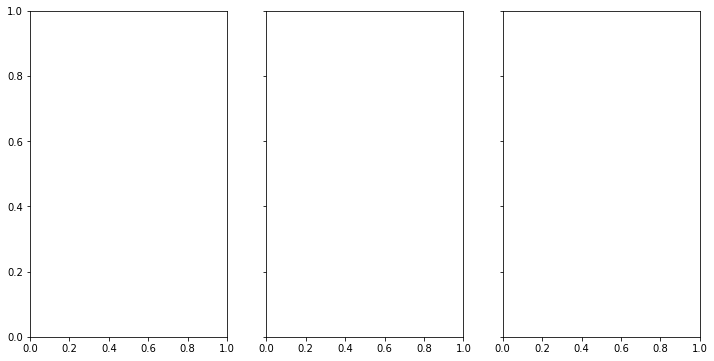

In [128]:
hier_c=hier_est.sel(pot="A")

fig, axis = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
c="A"
random_subset = rng.permutation(np.arange(len(hier_est["chain_draw"])))[:200]
hier_c = hier_est.sel(pot=c)
hier_means = hier_post.sel(pot=c).mean()
# plot all samples
axis[0].plot(xvals, hier_c.isel(chain_draw=random_subset), color="C1", alpha=0.1)
# plot mean
axis[0].plot(
    xvals,
    hier_means["a"] + hier_means["b"] * xvals,
    color="C1",
    alpha=1,
    lw=2.0,
    label="hierarchical",
)

ValueError: x and y can be no greater than 2D, but have shapes (10,) and (10, 200, 100)

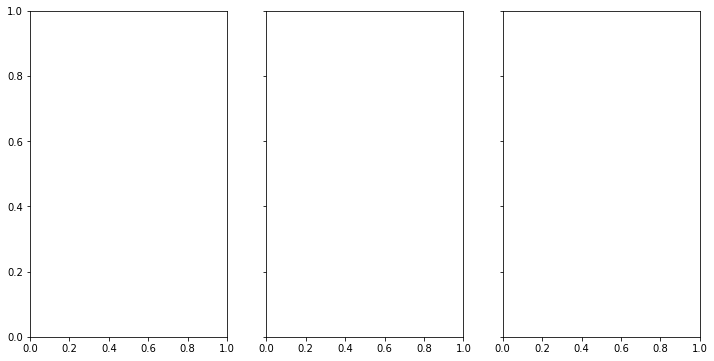

In [118]:
fig, axis = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()



for i, c in enumerate(selection):
    """
    ### unpooled model ###
    unpooled_c = unpooled_est.sel(county=c)
    unpooled_means = unpooled_post.sel(county=c).mean()
    # plot all samples from unpooled model
    axis[i].plot(xvals, unpooled_c.isel(chain_draw=random_subset), color="C0", alpha=0.1)
    # plot mean from unpooled model
    axis[i].plot(
        xvals,
        unpooled_means["a"] + unpooled_means["b"] * xvals,
        color="C0",
        alpha=1,
        lw=2.0,
        label="unpooled",
    )
    """
    ### hierarchical model ##
    hier_c = hier_est.sel(pot=c)
    hier_means = hier_post.sel(pot=c).mean()
    # plot all samples
    axis[i].plot(xvals, hier_c.isel(chain_draw=random_subset), color="C1", alpha=0.1)
    # plot mean
    axis[i].plot(
        xvals,
        hier_means["a"] + hier_means["b"] * xvals,
        color="C1",
        alpha=1,
        lw=2.0,
        label="hierarchical",
    )
    """[summary]
    # observed_data
    obs_data_c = observed_data.where(obs_county.isin(selection), drop=True)
    axis[i].scatter(
        obs_data_c["floor"] + rng.normal(scale=0.01, size=len(obs_data_c["floor"])),
        obs_data_c["y"],
        alpha=0.5,
        color="k",
        marker=".",
        s=80,
        zorder=3,
        label="original data",
    )
    """
    axis[i].set_xticks([0, 1])
    axis[i].set_xticklabels(["basement", "no basement"])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i % 3:
        axis[i].legend()
        axis[i].set_ylabel("log radon level")